In [ ]:
!pip install pycocotools

from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# from keras.layers.merge import add
from keras.layers import concatenate

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373756 sha256=131845761bb1b0270aa86ed6d8fa30d631efc73464ed1c82df33f416ced0396a
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Prepare Dataset

In [ ]:
coco=COCO("../input/cocods/annotations_trainval2017/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=21.34s)
creating index...
index created!


#### Find Categories

In [ ]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

Number of main categories:  12
List of main categories:  ['furniture', 'person', 'animal', 'food', 'electronic', 'kitchen', 'indoor', 'appliance', 'sports', 'outdoor', 'vehicle', 'accessory']


#### Find Sub Categories

In [ ]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


#### Find Sub categories with its corresponding IDs

In [ ]:
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

Sub categories with IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'c

#### Find total images with each sub categories

In [ ]:
subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds: 
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img
    
print("Sub categories with Image IDs :",len(subcategories_imageIds))

Sub categories with Image IDs : 80


In [ ]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

Total images in each sub categories:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch': 44

In [ ]:
subcategories_imageIds['donut'][:10]

[24577, 73733, 475142, 466960, 393243, 32801, 352295, 548906, 335922, 335928]

Here, I have selected category **donut** for accomplishing image caption generator project.

In [ ]:
train_cats = subcategories_imageIds['donut']
imgIdss = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIdss))

Total Images:  1523


#### Load some of the random images

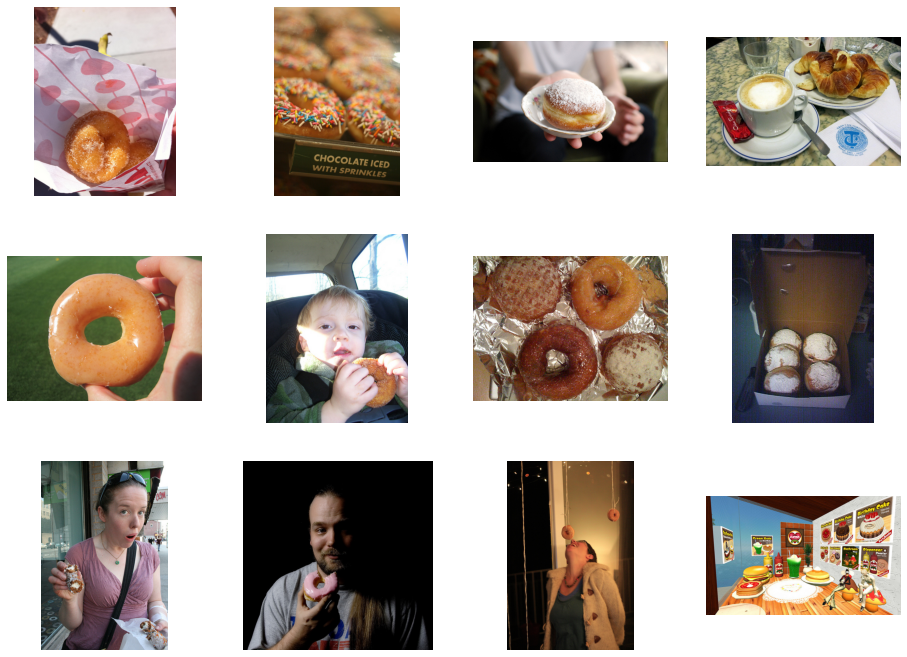

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

#### Load some of the random images with segmented objects inside them 

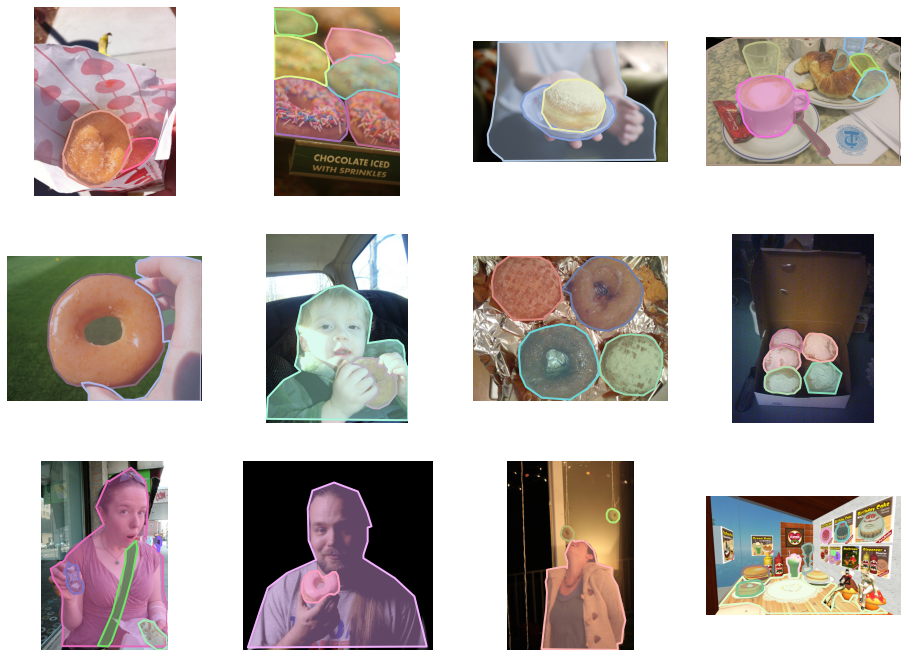

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    # print(anns)
    coco.showAnns(anns)
    

plt.show()

#### Load images with keypoints objects

In [ ]:
annFile = "../input/cocods/annotations_trainval2017/annotations/person_keypoints_train2017.json"
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=9.54s)
creating index...
index created!


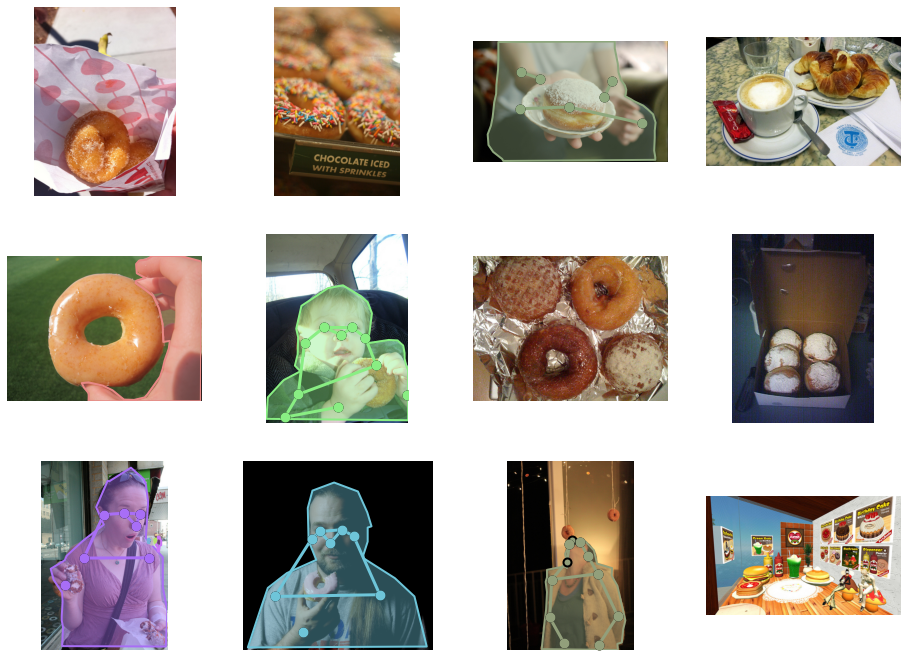

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

#### Load images with respective captions

In [ ]:
annFile = "../input/cocods/annotations_trainval2017/annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=1.68s)
creating index...
index created!


There are two sugar donuts left in the bag. 
A small pastry in a paper bag container.
A bag filled with sugary donuts stacked on top of each other.
Two donuts in a red and white paper bag.
a pastry in a paper bag with red dot designs on it.


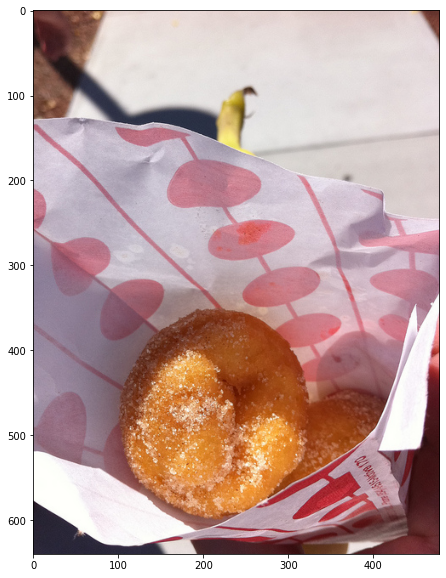

In [ ]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

# Image caption generator
#### Here I have taken "Donut" images and captions only.


In [ ]:
print("Total images for training: ", len(imgIdss))

Total images for training:  1523


# Prepare Dataset 

#### Group all captions together having the same image and store them in dict.

In [ ]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss[:]:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - to blank
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # join word list into sentence and <start> and <end> tag to each sentence which helps 
        # LSTM encoder-decoder model while training.
        
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
    
print("Length of Dataset: ",len(dataset))

Length of Dataset:  1523


In [ ]:
print(imgIdss[1])

525459


In [ ]:
print (list(dataset.keys())[1])
dataset[str(list(dataset.keys())[1])]

http://images.cocodataset.org/train2017/000000525459.jpg


['<start> a number of decorated donuts on a table <end>',
 '<start> a tray of donuts labeled chocolate iced with sprinkles <end>',
 '<start> a close up of a tray of donuts with sprinkles <end>',
 '<start> a sign showing that its a tray of chocolate sprinkle doughnuts <end>',
 '<start> chocolate iced donuts with sprinkles are on a tray <end>']

# Preprocess and tokenize the captions

In [ ]:
from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("donut ID: ", tokenizer.word_index['donut'])

Vocabulary length:  2968
donut ID:  11


In [ ]:
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import concatenate
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D


def ssd300_body(x):
    
    source_layers = []

    # Block 1
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_1', activation='relu')(x)
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_2', activation='relu')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same', name='pool1')(x)
    # Block 2
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_1', activation='relu')(x)
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_2', activation='relu')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same', name='pool2')(x)
    # Block 3
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_2', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_3', activation='relu')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same', name='pool3')(x)
    # Block 4
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_3', activation='relu')(x)
    source_layers.append(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same', name='pool4')(x)
    # Block 5
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_3', activation='relu')(x)
    x = MaxPool2D(pool_size=3, strides=1, padding='same', name='pool5')(x)
    # FC6
    x = Conv2D(1024, 3, strides=1, dilation_rate=(6, 6), padding='same', name='fc6', activation='relu')(x)
    # FC7
    x = Conv2D(1024, 1, strides=1, padding='same', name='fc7', activation='relu')(x)
    source_layers.append(x)
    # Block 6
    x = Conv2D(256, 1, strides=1, padding='same', name='conv6_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(512, 3, strides=2, padding='valid', name='conv6_2', activation='relu')(x)
    source_layers.append(x)
    # Block 7
    x = Conv2D(128, 1, strides=1, padding='same', name='conv7_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv7_2', activation='relu')(x)
    source_layers.append(x)
    # Block 8
    x = Conv2D(128, 1, strides=1, padding='same', name='conv8_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='valid', name='conv8_2', activation='relu')(x)
    source_layers.append(x)
    # Block 9
    x = Conv2D(128, 1, strides=1, padding='same', name='conv9_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='valid', name='conv9_2', activation='relu')(x)
    source_layers.append(x)
    
    return source_layers

def multibox_head(source_layers, num_priors):

    feature = []
    for i in range(len(source_layers)):
        x = source_layers[i]
        name = x.name.split('/')[0]
            
        # confidence
        name1 = name + '_feature'
        x1 = Conv2D(2048, 3, padding='same', name=name1)(x)
        x1 = Flatten(name=name1+'_flat')(x1)
        feature.append(x1)
        
    feature = concatenate(feature, axis=1, name='feature')
    feature = Reshape((-1, 2048), name='feature_logits')(feature)
    feature = GlobalAveragePooling1D(data_format='channels_last')(feature)
    
    return feature
        
def SSD300(input_shape=(299, 299, 3)):
    
    x = input_tensor = Input(shape=input_shape)
    source_layers = ssd300_body(x)
    
    # Add multibox head for classification and regression
    num_priors = [4, 6, 6, 6, 4, 4]

    output_tensor = multibox_head(source_layers, num_priors)
    model = Model(input_tensor, output_tensor)
    
    return model
body = ssd300_body(x = Input(shape=(299,299,3)))
print ("The output of the SSD300_body\n",body)
SSD300_model = SSD300()
SSD300_model.summary()
print (SSD300_model)

The output of the SSD300_body
 [<KerasTensor: shape=(None, 38, 38, 512) dtype=float32 (created by layer 'conv4_3')>, <KerasTensor: shape=(None, 19, 19, 1024) dtype=float32 (created by layer 'fc7')>, <KerasTensor: shape=(None, 10, 10, 512) dtype=float32 (created by layer 'conv6_2')>, <KerasTensor: shape=(None, 5, 5, 256) dtype=float32 (created by layer 'conv7_2')>, <KerasTensor: shape=(None, 3, 3, 256) dtype=float32 (created by layer 'conv8_2')>, <KerasTensor: shape=(None, 1, 1, 256) dtype=float32 (created by layer 'conv9_2')>]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 299, 299, 64) 1

In [ ]:
image_features = {}
for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Resize each image size 299 x 299
    image = cv2.resize(image,(299,299))
    image = np.expand_dims(image, axis=0)
    
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0

    # Extract features from image
    feature = SSD300_model.predict(image)
    image_features[img] = feature
    
print("Image features length: ", len(image_features))

  0%|          | 0/1523 [00:00<?, ?it/s]

Image features length:  1523


In [ ]:
print ("Shape of the output feature\n",image_features[str(list(dataset.keys())[1])].shape)
print ("Features of the output\n",image_features[str(list(dataset.keys())[1])])

Shape of the output feature
 (1, 2048)
Features of the output
 [[ 3.3414431e-03  1.5170046e-04  1.4111014e-03 ... -5.3766440e-04
   9.9258112e-05  1.5448251e-04]]


Here, I have found the max_length among the captions which will help to pad each caption with the same length.

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

42

In [ ]:
#create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)


In [ ]:
# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    # decoder1 = add([fe2, se3])
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())

    return model


# Train and test the model

In [ ]:
# train our model
print('Dataset: ', len(dataset))
print('Descriptions: train=', len(dataset))
print('Photos: train=', len(image_features))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

model = define_model(total_words, max_length)
epochs = 10
steps = len(dataset)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./model_{epoch:02d}.h5', 
                                    save_freq='epoch',
                                    monitor='loss',
                                    mode='min',
                                    save_best_only=True,
                                    period = 3),

# for i in range(epochs):
generator = data_generator(dataset, image_features, tokenizer, max_length)
history = model.fit(generator, epochs=epochs, steps_per_epoch= steps, verbose=1,callbacks = checkpoint)
model.save("./best_model.h5")
    

Dataset:  1523
Descriptions: train= 1523
Photos: train= 1523
Vocabulary Size: 2968
Description Length:  42
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 256)      759808      input_8[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_7[0][0]      

dict_keys(['loss'])


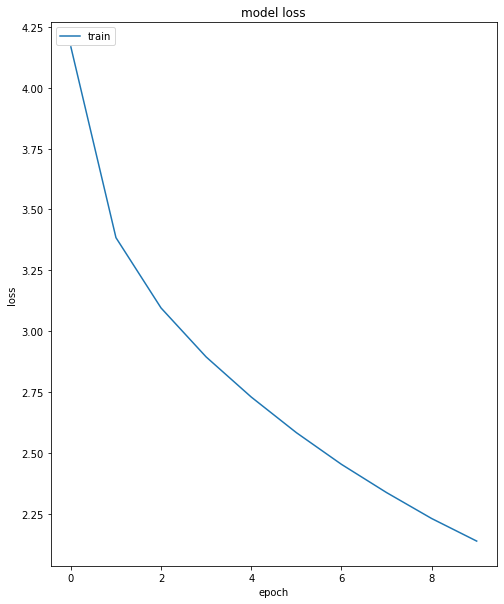

In [ ]:
def plot_train (history):
    # list all data in history
    print(history.history.keys())

    # summarize history for loss

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
plot_train(history)




start a man eating a donut with a bite missing end
Feature
 [[ 4.7271475e-03  9.8545323e-05  2.1913769e-03 ... -4.1973821e-04
   1.7066472e-04  4.3288476e-04]]


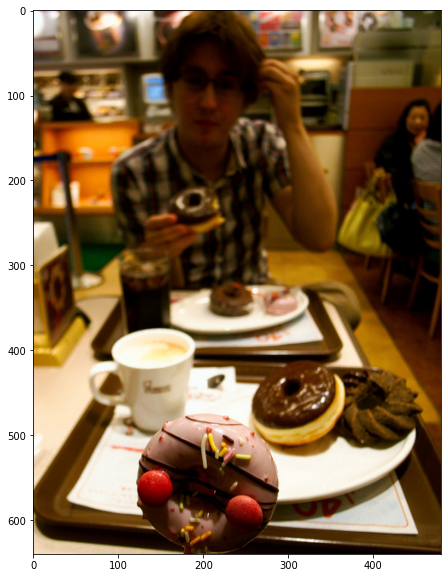

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


img_paths = ["../input/cocods/val2017/val2017/000000035682.jpg",
]

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text


#max_length = 46

model = load_model('/kaggle/working/best_model.h5')

photo = extract_features(img_paths[0], SSD300_model)
img = Image.open(img_paths[0])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
print ("Feature\n", photo)
plt.imshow(img)

Image size:  (640, 480, 3)
hog_image
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          4.03577618  2.13514236 ...  2.68655792  1.42801198
   0.        ]
 [ 0.          2.13514236  4.03577618 ...  1.42801198  2.68655792
   0.        ]
 ...
 [ 0.          1.31712194  1.17117303 ... 15.58359241  4.69573021
   0.        ]
 [ 0.          1.17117303  1.31712194 ...  4.69573021 15.58359241
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


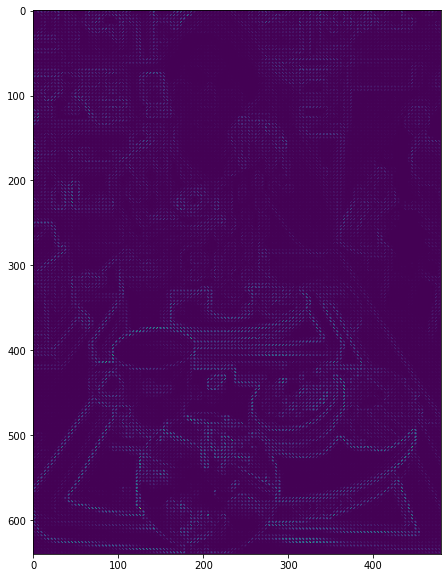

In [ ]:
from skimage.feature import hog

def hog_images(crop):    
    image=crop[:,:,1]    
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(2, 2), visualize=True)    
    return hog_image

img_paths = ["../input/cocods/val2017/val2017/000000035682.jpg"]
im = cv2.imread(img_paths[0])
print ("Image size: ", im.shape)
hog_image = hog_images(im)
plt.imshow(hog_image)

print ('hog_image\n',hog_image)

normalized hog_matrix
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.31230895 0.47924589 ... 0.27521336 0.29988929 0.        ]
 [0.         0.47924589 0.31230895 ... 0.29988929 0.27521336 0.        ]
 ...
 [0.         0.85309372 0.02761826 ... 0.61641638 0.28284206 0.        ]
 [0.         0.02761826 0.85309372 ... 0.28284206 0.61641638 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
hog_vec
 [0. 0. 0. ... 0. 0. 0.]


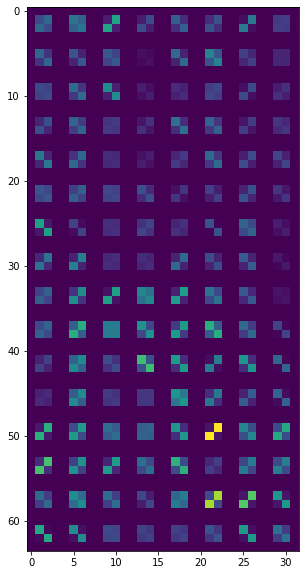

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

im = cv2.resize (im, (32,64))
hog_image = hog_images(im)
plt.imshow(hog_image)

hog_image = np.array(hog_image)
scaler.fit(hog_image)
scaler.transform(hog_image)
print ('normalized hog_matrix\n',scaler.transform(hog_image))
hog_vec = hog_image.flatten()

print ('hog_vec\n',hog_vec)